# White-box Attack on Tiny ImageNet

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
# TODO: Specify your path here
new_directory = "/content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj"
os.chdir(new_directory)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj


In [3]:
import sys
#
import torch
import torch.nn as nn

#sys.path.insert(0, '..')
# import torchattacks

In [4]:
%cd adversarial-attacks-pytorch
import torchattacks
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
%cd ..

/content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj/adversarial-attacks-pytorch
/content/gdrive/Othercomputers/Mein MacBook Pro/GDrive/dl_proj


In [5]:
# imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter
from utils.parsers import get_training_parser
from utils.optimizer import get_optimizer, get_scheduler, OPTIMIZERS_DICT, SCHEDULERS

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt
import argparse
import time

In [6]:
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

#torch.manual_seed(0)

In [7]:
from torchattacks import PGD
from utils_attack import *

In [8]:
device = 'cuda' #cpu
print(torch.cuda.is_available())

True


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Assuming a single-GPU setup
    device_properties = torch.cuda.get_device_properties(device)

    total_memory = device_properties.total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    print(f"Total GPU Memory: {total_memory / 1e9} GB")
    print(f"Allocated Memory: {allocated_memory / 1e9} GB")
    print(f"Cached Memory: {cached_memory / 1e9} GB")
else:
    print("CUDA is not available.")

Total GPU Memory: 16.935682048 GB
Allocated Memory: 0.0 GB
Cached Memory: 0.0 GB


# Wrappers

In [10]:
class Model_Wrapper(nn.Module):
    def __init__(self, model, input_size):
        super(Model_Wrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = self.model(x)
        return x

In [11]:
class MLP_Wrapper(nn.Module):
    def __init__(self, model, input_size):
        super(MLP_Wrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = x.flatten(1)
        x = self.model(x)
        return x

# LOAD MLP

In [12]:
torch.backends.cuda.matmul.allow_tf32 = True

In [13]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
eval_batch_size = 1024
checkpoint = 'in21k_imagenet'

# bypass ing
num_classes = 1000
input_size = 64
model_mlp = get_model(architecture=architecture, resolution=input_size, num_classes=num_classes, checkpoint=checkpoint)
model_mlp.linear_out = nn.Linear(1024, 200)

model_full_path = os.path.join("checkpoints", "mlp_b12_wi1024_imagenet_bs128_tinyimagenet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_mlp = torch.nn.DataParallel(model_mlp)
model_mlp.load_state_dict(checkpoint['model'])
model_mlp.eval()

Weights already downloaded
Load_state output <All keys matched successfully>


DataParallel(
  (module): BottleneckMLP(
    (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
    (linear_out): Linear(in_features=1024, out_features=200, bias=True)
    (blocks): ModuleList(
      (0-11): 12 x BottleneckBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (layernorms): ModuleList(
      (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [14]:
model_mlp_wrap = MLP_Wrapper(model_mlp, input_size=64)

model_mlp_wrap = model_mlp_wrap.to(device)
model_mlp_wrap.eval()

MLP_Wrapper(
  (model): DataParallel(
    (module): BottleneckMLP(
      (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
      (linear_out): Linear(in_features=1024, out_features=200, bias=True)
      (blocks): ModuleList(
        (0-11): 12 x BottleneckBlock(
          (block): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=4096, out_features=1024, bias=True)
          )
        )
      )
      (layernorms): ModuleList(
        (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (resize): Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
)

# LOAD CNN

In [15]:
num_classes = 200
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, num_classes)

model_full_path = os.path.join("checkpoints", "ResNet18_TinyImageNet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_resnet = torch.nn.DataParallel(model_resnet)
model_resnet.load_state_dict(checkpoint['model'])
##
model_resnet_wrap = Model_Wrapper(model_resnet, 224)
model_resnet_wrap.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


Model_Wrapper(
  (model): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

# LOAD ViT

In [16]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00


In [17]:
import timm
model_vit = timm.create_model("vit_tiny_patch16_224", pretrained=True)
model_vit.head = nn.Linear(model_vit.head.in_features, 200) # tinyimagnet


model_full_path = os.path.join("checkpoints", "vit_tiny_patch16_224_unfrozen_tinyimagenet.t7")
checkpoint = torch.load(model_full_path, map_location=torch.device(device))

model_vit = torch.nn.DataParallel(model_vit)
model_vit.load_state_dict(checkpoint['model'])
model_vit = model_vit.to(device)
model_vit.eval()

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')


In [18]:
input_size = 224
model_vit_wrap = Model_Wrapper(model_vit, input_size=input_size)

model_vit_wrap = model_vit_wrap.to(device)
model_vit_wrap.eval()

Model_Wrapper(
  (model): DataParallel(
    (module): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=19

# LOAD DATA

In [19]:
!pip install datasets[vision]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [24]:
from datasets import load_dataset, get_dataset_split_names
import cv2

bs = 100
testset = load_dataset('Maysee/tiny-imagenet', split='valid')

transform_mean = [0.485, 0.456, 0.406]
transform_std = [0.229, 0.224, 0.225]

input_size = 64

transform_test = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

from PIL import Image

def collate_fn_test(batch):
  return ((torch.stack([transform_test(Image.fromarray(cv2.cvtColor(np.array(x['image']),cv2.COLOR_GRAY2RGB))) if np.array(x['image']).ndim == 2 else transform_test(x['image']) for x in batch])), torch.tensor([x['label'] for x in batch]))

testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=1, collate_fn=collate_fn_test)

class_ids = ["n01443537", "n01629819", "n01641577", "n01644900", "n01698640", "n01742172", "n01768244", "n01770393", "n01774384", "n01774750", "n01784675", "n01882714", "n01910747", "n01917289", "n01944390", "n01950731", "n01983481", "n01984695", "n02002724", "n02056570", "n02058221", "n02074367", "n02094433", "n02099601", "n02099712", "n02106662", "n02113799", "n02123045", "n02123394", "n02124075", "n02125311", "n02129165", "n02132136", "n02165456", "n02226429", "n02231487", "n02233338", "n02236044", "n02268443", "n02279972", "n02281406", "n02321529", "n02364673", "n02395406", "n02403003", "n02410509", "n02415577", "n02423022", "n02437312", "n02480495", "n02481823", "n02486410", "n02504458", "n02509815", "n02666347", "n02669723", "n02699494", "n02769748", "n02788148", "n02791270", "n02793495", "n02795169", "n02802426", "n02808440", "n02814533", "n02814860", "n02815834", "n02823428", "n02837789", "n02841315", "n02843684", "n02883205", "n02892201", "n02909870", "n02917067", "n02927161", "n02948072", "n02950826", "n02963159", "n02977058", "n02988304", "n03014705", "n03026506", "n03042490", "n03085013", "n03089624", "n03100240", "n03126707", "n03160309", "n03179701", "n03201208", "n03255030", "n03355925", "n03373237", "n03388043", "n03393912", "n03400231", "n03404251", "n03424325", "n03444034", "n03447447", "n03544143", "n03584254", "n03599486", "n03617480", "n03637318", "n03649909", "n03662601", "n03670208", "n03706229", "n03733131", "n03763968", "n03770439", "n03796401", "n03814639", "n03837869", "n03838899", "n03854065", "n03891332", "n03902125", "n03930313", "n03937543", "n03970156", "n03977966", "n03980874", "n03983396", "n03992509", "n04008634", "n04023962", "n04070727", "n04074963", "n04099969", "n04118538", "n04133789", "n04146614", "n04149813", "n04179913", "n04251144", "n04254777", "n04259630", "n04265275", "n04275548", "n04285008", "n04311004", "n04328186", "n04356056", "n04366367", "n04371430", "n04376876", "n04398044", "n04399382", "n04417672", "n04456115", "n04465666", "n04486054", "n04487081", "n04501370", "n04507155", "n04532106", "n04532670", "n04540053", "n04560804", "n04562935", "n04596742", "n04598010", "n06596364", "n07056680", "n07583066", "n07614500", "n07615774", "n07646821", "n07647870", "n07657664", "n07695742", "n07711569", "n07715103", "n07720875", "n07749582", "n07753592", "n07768694", "n07871810", "n07873807", "n07875152", "n07920052", "n07975909", "n08496334", "n08620881", "n08742578", "n09193705", "n09246464", "n09256479", "n09332890", "n09428293", "n12267677", "n12520864", "n13001041", "n13652335", "n13652994", "n13719102", "n14991210"]
class_names = ['goldfish, Carassius auratus', 'European fire salamander, Salamandra salamandra', 'bullfrog, Rana catesbeiana', 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'American alligator, Alligator mississipiensis', 'boa constrictor, Constrictor constrictor', 'trilobite', 'scorpion', 'black widow, Latrodectus mactans', 'tarantula', 'centipede', 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'jellyfish', 'brain coral', 'snail', 'sea slug, nudibranch', 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'black stork, Ciconia nigra', 'king penguin, Aptenodytes patagonica', 'albatross, mollymawk', 'dugong, Dugong dugon', 'Yorkshire terrier', 'golden retriever', 'Labrador retriever', 'German shepherd, German shepherd dog, German police dog, alsatian', 'standard poodle', 'tabby, tabby cat', 'Persian cat', 'Egyptian cat', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'brown bear, bruin, Ursus arctos', 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'grasshopper, hopper', 'walking stick, walkingstick, stick insect', 'cockroach, roach', 'mantis, mantid', "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'sulphur butterfly, sulfur butterfly', 'sea cucumber, holothurian', 'guinea pig, Cavia cobaya', 'hog, pig, grunter, squealer, Sus scrofa', 'ox', 'bison', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'gazelle', 'Arabian camel, dromedary, Camelus dromedarius', 'orangutan, orang, orangutang, Pongo pygmaeus', 'chimpanzee, chimp, Pan troglodytes', 'baboon', 'African elephant, Loxodonta africana', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'abacus', "academic gown, academic robe, judge's robe", 'altar', 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'bannister, banister, balustrade, balusters, handrail', 'barbershop', 'barn', 'barrel, cask', 'basketball', 'bathtub, bathing tub, bath, tub', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'beacon, lighthouse, beacon light, pharos', 'beaker', 'beer bottle', 'bikini, two-piece', 'binoculars, field glasses, opera glasses', 'birdhouse', 'bow tie, bow-tie, bowtie', 'brass, memorial tablet, plaque', 'bucket, pail', 'bullet train, bullet', 'butcher shop, meat market', 'candle, taper, wax light', 'cannon', 'cardigan', 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'CD player', 'chest', 'Christmas stocking', 'cliff dwelling', 'computer keyboard, keypad', 'confectionery, confectionary, candy store', 'convertible', 'crane', 'dam, dike, dyke', 'desk', 'dining table, board', 'dumbbell', 'flagpole, flagstaff', 'fly', 'fountain', 'freight car', 'frying pan, frypan, skillet', 'fur coat', 'gasmask, respirator, gas helmet', 'go-kart', 'gondola', 'hourglass', 'iPod', 'jinrikisha, ricksha, rickshaw', 'kimono', 'lampshade, lamp shade', 'lawn mower, mower', 'lifeboat', 'limousine, limo', 'magnetic compass', 'maypole', 'military uniform', 'miniskirt, mini', 'moving van', 'neck brace', 'obelisk', 'oboe, hautboy, hautbois', 'organ, pipe organ', 'parking meter', 'pay-phone, pay-station', 'picket fence, paling', 'pill bottle', "plunger, plumber's helper", 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'poncho', 'pop bottle, soda bottle', "potter's wheel", 'projectile, missile', 'punching bag, punch bag, punching ball, punchball', 'refrigerator, icebox', 'remote control, remote', 'rocking chair, rocker', 'rugby ball', 'sandal', 'school bus', 'scoreboard', 'sewing machine', 'snorkel', 'sock', 'sombrero', 'space heater', "spider web, spider's web", 'sports car, sport car', 'steel arch bridge', 'stopwatch, stop watch', 'sunglasses, dark glasses, shades', 'suspension bridge', 'swimming trunks, bathing trunks', 'syringe', 'teapot', 'teddy, teddy bear', 'thatch, thatched roof', 'torch', 'tractor', 'triumphal arch', 'trolleybus, trolley coach, trackless trolley', 'turnstile', 'umbrella', 'vestment', 'viaduct', 'volleyball', 'water jug', 'water tower', 'wok', 'wooden spoon', 'comic book', 'reel', 'guacamole', 'ice cream, icecream', 'ice lolly, lolly, lollipop, popsicle', 'goose', 'drumstick', 'plate', 'pretzel', 'mashed potato', 'cauliflower', 'bell pepper', 'lemon', 'banana', 'pomegranate', 'meat loaf, meatloaf', 'pizza, pizza pie', 'potpie', 'espresso', 'bee', 'apron', 'pole', 'Chihuahua', 'alp', 'cliff, drop, drop-off', 'coral reef', 'lakeside, lakeshore', 'seashore, coast, seacoast, sea-coast', 'acorn', 'broom', 'mushroom', 'nail', 'chain', 'slug', 'orange']

In [21]:
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
from tqdm import tqdm


In [25]:
print('[Data loaded]')

acc_mlp_list = []
acc_cnn_list = []
acc_vit_list = []

for batch in tqdm(testloader):
    images, labels = batch
    acc_mlp = clean_accuracy(model_mlp_wrap, images.to(device), labels.to(device))
    acc_mlp_list.append(acc_mlp)

    acc_cnn = clean_accuracy(model_resnet_wrap, images.to(device), labels.to(device))
    acc_cnn_list.append(acc_cnn)

    acc_vit = clean_accuracy(model_vit_wrap, images.to(device), labels.to(device))
    acc_vit_list.append(acc_vit)

[Data loaded]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


In [26]:
acc_mlp = np.array(acc_mlp_list)
acc = acc_mlp.mean()
print('[MLP loaded]')
print('MLP Acc: %2.2f %%'%(acc*100))

acc_cnn = np.array(acc_cnn_list)
acc = acc_cnn.mean()
print('[CNN loaded]')
print('CNN Acc: %2.2f %%'%(acc*100))

acc_vit = np.array(acc_vit_list)
acc = acc_vit.mean()
print('[ViT loaded]')
print('ViT Acc: %2.2f %%'%(acc*100))

[MLP loaded]
MLP Acc: 72.74 %
[CNN loaded]
CNN Acc: 70.03 %
[ViT loaded]
ViT Acc: 73.75 %


# Testing if torchattacks library works

In [ ]:
for batch in testloader:
  images, labels = batch
  break

In [ ]:
sample = 0
img = images[sample].unsqueeze(0).to(device)
labl = labels[sample].unsqueeze(0).to(device)

In [ ]:
atk_cnn2 = PGD(model_resnet_wrap, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_cnn2.set_normalization_used(mean=transform_mean, std=transform_std)

In [ ]:
adv_img = atk_cnn2(img, labl)

prediction1 = get_pred(model_resnet_wrap, adv_img, device)

prediction2 = model_resnet_wrap(adv_img)
prediction2 = torch.argmax(prediction2, dim=1)


In [ ]:
print("prediction1:", prediction1.item())
print("prediction2:", prediction2.item())
print("true label:",labl.item())

prediction1: 49
prediction2: 49
true label: 0


In [ ]:
un_adv_img = atk_cnn2.inverse_normalize(adv_img)

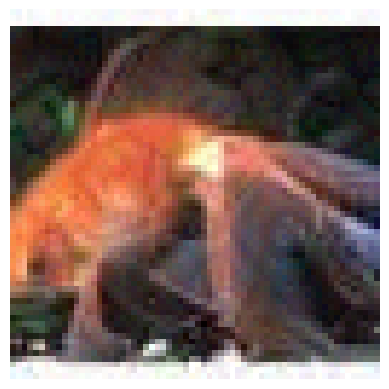

In [ ]:
# Perturbed image
image_np = un_adv_img[0].detach().permute(1, 2, 0).cpu().numpy()
plt.imshow(image_np)
plt.axis('off')
plt.show()

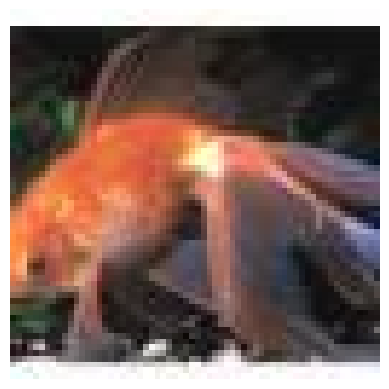

In [ ]:
# Original image
image_np = atk_cnn2.inverse_normalize(img)[0].detach().permute(1, 2, 0).cpu().numpy()
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [ ]:
normalize = transforms.Normalize(mean, std)

def clamp_to_img(x):
  return torch.clamp(x, min=0., max=1.)

In [ ]:
def pga(model, images, labels, eps=2/255, lr_pga=2/225, iters=20, device="cpu"):
  # Initialize the perturbation as a variable with gradient since we will optimize over it


  r = torch.empty_like(images).uniform_(-eps, eps).to(device)
  r.requires_grad_()
  #r = images + torch.rand_like(images, requires_grad=True).to(device)

  for i in range(iters):
      # Calculate the logits for the perturbed image
      logits = model(normalize(clamp_to_img(images + r)))
      # Get the cross entropy loss
      loss = F.cross_entropy(logits, labels)
      # Calculate the gradient w.r.t. to the perturbation eta
      loss.backward()

      if i % 1 == 0:
            print(f'Iteration {i}: Loss: {loss.item()}')
      # Perform gradient ascent step
      r.data +=  lr_pga * r.grad.data
      # Clamp the perturbation to be between -eps and eps
      r.data = torch.clamp(r.data, -eps, eps)

  adv_images = clamp_to_img(images + r)
  return adv_images

# Experiments

In [27]:
def compare_adv_attacks(model1, model2, atk_model1, images, labels, device='cpu'):

    model1.eval()
    model2.eval()

    successful_adv_attacks_model1 = []
    successful_adv_attacks_model2 = []


    adv_images = atk_model1(images, labels)
    predictions = model1(adv_images)
    predictions = torch.argmax(predictions, dim=1)
    #predictions = get_pred(model1, adv_images, device)
    #predictions = predictions.cuda()

    seccessful_adv_images = adv_images[predictions != labels]
    true_labels_of_succ_adv_images = labels[predictions != labels]
    successful_adv_attacks_model1.append(seccessful_adv_images.shape[0])

    predictions = model2(seccessful_adv_images)
    predictions = torch.argmax(predictions, dim=1)
    #predictions = get_pred(model2, seccessful_adv_images, device)
    #predictions = predictions.cuda()
    seccessful_adv_images = seccessful_adv_images[predictions != true_labels_of_succ_adv_images]
    successful_adv_attacks_model2.append(seccessful_adv_images.shape[0])

    return successful_adv_attacks_model1, successful_adv_attacks_model2




# MLP vs Resnet18 experiment

In [ ]:
N_exp = 10

atk_mlp = PGD(model_mlp_wrap, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_mlp.set_normalization_used(mean=transform_mean, std=transform_std)


l1_list_mlp = []
l2_list_mlp = []
# 100 batches
for i,batch in enumerate(testloader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []

    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_mlp_wrap(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_resnet_wrap(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]

    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_mlp_wrap, model_resnet_wrap, atk_mlp, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_mlp.append(ll1_list)
    l2_list_mlp.append(ll2_list)

In [ ]:
# Trained on mlp Tested on resnet

In [29]:
mlp_adv = np.array(l1_list_mlp)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

cnn_adv = np.array(l2_list_mlp)
cnn_adv = np.squeeze(cnn_adv,2)
cnn_adv = cnn_adv.sum(axis=0)

cnn_adv_mean = cnn_adv.mean(axis=0)
cnn_adv_std = cnn_adv.std(axis=0)
print('cnn_adv_mean: ', cnn_adv_mean)
print('cnn_adv_std: ', cnn_adv_std)



mlp_adv_mean:  5908.9
mlp_adv_std:  0.3
cnn_adv_mean:  1139.6
cnn_adv_std:  13.207573584879245


In [30]:
print("ratio: ", (cnn_adv_mean/mlp_adv_mean)*100)

ratio:  19.28616155291171


In [ ]:
N_exp = 10

atk_cnn = PGD(model_resnet_wrap, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_cnn.set_normalization_used(mean=transform_mean, std=transform_std)


l1_list_cnn = []
l2_list_cnn = []
# 100 batches
for i,batch in enumerate(testloader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []

    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_resnet_wrap(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_mlp_wrap(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]

    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_resnet_wrap, model_mlp_wrap, atk_cnn, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_cnn.append(ll1_list)
    l2_list_cnn.append(ll2_list)

In [ ]:
# Trained on resnet Tested on mlp

In [32]:
cnn_adv = np.array(l1_list_cnn)
cnn_adv = np.squeeze(cnn_adv,2)
cnn_adv = cnn_adv.sum(axis=0)

cnn_adv_mean = cnn_adv.mean(axis=0)
cnn_adv_std = cnn_adv.std(axis=0)
print('cnn_adv_mean: ', cnn_adv_mean)
print('cnn_adv_std: ', cnn_adv_std)

mlp_adv = np.array(l2_list_cnn)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

cnn_adv_mean:  5909.9
cnn_adv_std:  0.3
mlp_adv_mean:  386.3
mlp_adv_std:  11.04581368664165


In [33]:
print("ratio: ", (mlp_adv_mean/cnn_adv_mean)*100)

ratio:  6.536489619113691


# MLP vs ViT experiment

In [ ]:
N_exp = 10

atk_mlp = PGD(model_mlp_wrap, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_mlp.set_normalization_used(mean=transform_mean, std=transform_std)


l1_list_mlp = []
l2_list_mlp = []
# 100 batches
for i,batch in enumerate(testloader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []

    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_mlp_wrap(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_vit_wrap(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]


    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_mlp_wrap, model_vit_wrap, atk_mlp, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_mlp.append(ll1_list)
    l2_list_mlp.append(ll2_list)

In [ ]:
# Trained on mlp Tested on vit

In [38]:
mlp_adv = np.array(l1_list_mlp)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

vit_adv = np.array(l2_list_mlp)
vit_adv = np.squeeze(vit_adv,2)
vit_adv = vit_adv.sum(axis=0)

vit_adv_mean = vit_adv.mean(axis=0)
vit_adv_std = vit_adv.std(axis=0)
print('vit_adv_mean: ', vit_adv_mean)
print('vit_adv_std: ', vit_adv_std)

mlp_adv_mean:  6145.0
mlp_adv_std:  0.0
vit_adv_mean:  1238.0
vit_adv_std:  13.36413109783049


In [58]:
print("ratio: ", (vit_adv_mean/mlp_adv_mean)*100)

ratio:  20.14646053702197


In [ ]:
N_exp = 10

atk_vit = PGD(model_vit_wrap, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_vit.set_normalization_used(mean=transform_mean, std=transform_std)


l1_list_vit = []
l2_list_vit = []
# 100 batches
for i,batch in enumerate(testloader):
    print("batch:", i)
    ll1_list = []
    ll2_list = []


    # filter out images that are not correct
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    predictions = model_vit_wrap(images)
    predictions = torch.argmax(predictions, dim=1)

    predictions2 = model_mlp_wrap(images)
    predictions2 = torch.argmax(predictions2, dim=1)


    correct_images = images[(predictions == labels) & (predictions2==labels)]
    correct_labels = labels[(predictions == labels) & (predictions2==labels)]


    # N_exp times
    for i in range(N_exp):
        l1, l2 = compare_adv_attacks(model_vit_wrap, model_mlp_wrap, atk_vit, correct_images, correct_labels, device)
        ll1_list.append(l1)
        ll2_list.append(l2)

    l1_list_vit.append(ll1_list)
    l2_list_vit.append(ll2_list)

In [ ]:
# Trained on vit Tested on mlp

In [40]:
vit_adv = np.array(l1_list_vit)
vit_adv = np.squeeze(vit_adv,2)
vit_adv = vit_adv.sum(axis=0)

vit_adv_mean = vit_adv.mean(axis=0)
vit_adv_std = vit_adv.std(axis=0)
print('vit_adv_mean: ', vit_adv_mean)
print('vit_adv_std: ', vit_adv_std)

mlp_adv = np.array(l2_list_vit)
mlp_adv = np.squeeze(mlp_adv,2)
mlp_adv = mlp_adv.sum(axis=0)

mlp_adv_mean = mlp_adv.mean(axis=0)
mlp_adv_std = mlp_adv.std(axis=0)
print('mlp_adv_mean: ', mlp_adv_mean)
print('mlp_adv_std: ', mlp_adv_std)

vit_adv_mean:  6146.0
vit_adv_std:  0.0
mlp_adv_mean:  423.3
mlp_adv_std:  12.720455966670377


In [41]:
print("ratio: ", (mlp_adv_mean/vit_adv_mean)*100)

ratio:  6.8874064432151
